In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from scipy.signal import correlate2d
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

In [2]:
# Load and preprocess images
left_image = cv2.imread('../../data/Aloe/view0.png', cv2.IMREAD_GRAYSCALE).astype(np.float64)
right_image = cv2.imread('../../data/Aloe/view1.png', cv2.IMREAD_GRAYSCALE).astype(np.float64)

In [3]:
# Define Canny edge detection parameters
high_threshold = 0.01 * 255  # Scale the threshold to match OpenCV's range (0-255)
low_threshold = 0.4 * high_threshold  # MATLAB's 'edge' function automatically adjusts the high threshold

# Apply Canny edge detection
edge_right = cv2.Canny(right_image.astype(np.uint8), low_threshold, high_threshold)
edge_left = cv2.Canny(left_image.astype(np.uint8), low_threshold, high_threshold)

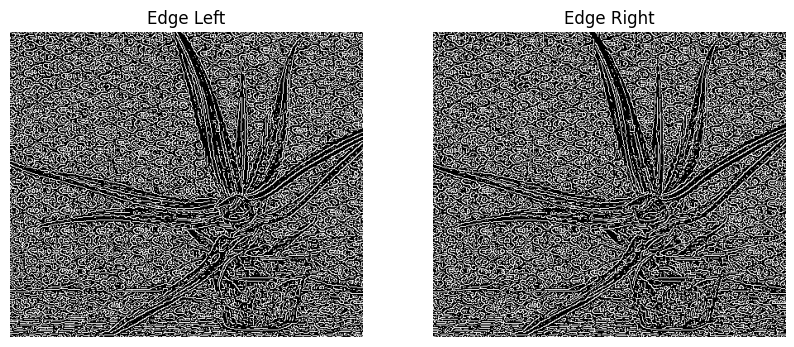

In [32]:
# Display the edge images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(edge_left, cmap='gray')
plt.title('Edge Left')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edge_right, cmap='gray')
plt.title('Edge Right')
plt.axis('off')

plt.show()


In [4]:
maxDisparity = 30
minDisparity = 0
maxOffset = 30
minOffset = 0

In [5]:
windowsize = 15
windowRange = np.arange(-windowsize,windowsize+1, 1)

In [6]:
height, width = right_image.shape

In [7]:
def patchwiseNCC(left_image, right_image, i, j, k, windowRange):
    # Extract 2D patches using np.ix_ to ensure valid indexing
    right_patch = right_image[np.ix_(i + windowRange, j + windowRange)]
    left_patch = left_image[np.ix_(i + windowRange, k + windowRange)]

    # Normalize patches
    right_patch = right_patch / np.sqrt(np.sum(right_patch ** 2))
    left_patch = left_patch / np.sqrt(np.sum(left_patch ** 2))

    # Compute normalized cross-correlation
    norm_cross_corr = correlate2d(right_patch, left_patch, mode='valid')

    return norm_cross_corr


In [15]:
def computeDisparityMap(left_image, right_image, edgeDet, windowsize, windowRange, height, width, maxOffset):
    disparityMap = np.zeros([height, width])
    dispnotoutofbounds = np.zeros([height, width])
    for i in range(windowsize, height-windowsize):
        for j in range(windowsize, width-windowsize):
            if(edgeDet[i][j]):
                maxcorr = patchwiseNCC(left_image, right_image, i, j, j, windowRange)
                for k in range(j+1, width-windowsize): #########################
                    corr = patchwiseNCC(left_image, right_image, i, j, k, windowRange)
                    if(maxcorr<corr):
                        disparityMap[i][j] = k-j
                        maxcorr = corr
                dispnotoutofbounds[i][j] = 1
                if(maxcorr<0.7 or disparityMap[i][j]>maxOffset): ######################
                    disparityMap[i][j] = 0
                    dispnotoutofbounds[i][j] = 0
                    edge_right[i][j] = 0 ###################
    return disparityMap, dispnotoutofbounds

In [42]:
disparityMap, dispnotoutofbounds = computeDisparityMap(left_image, right_image, edge_right, windowsize, windowRange, height, width, maxOffset)

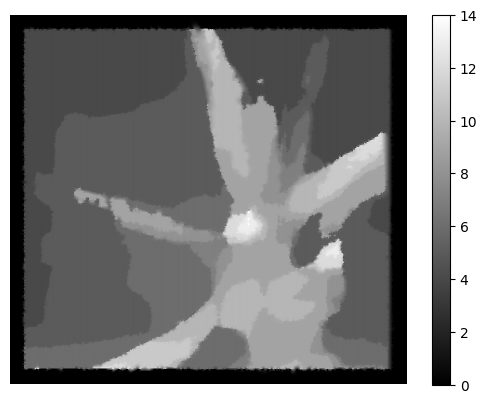

In [62]:
plt.imshow(disparityMap, cmap='gray', aspect='auto')  # Equivalent to imagesc
plt.colorbar()  # Add color scale
plt.axis('off')  # Hide axes if needed
plt.show()

In [9]:
def depthretrieval(disparityMap, iters, edge_right, height, width):
    depthMap = disparityMap
    for k in range(iters):
        for i in range(1, height-1):
            for j in range(1, width-1):
                if edge_right[i][j] == 0:
                    depthMap[i][j] = (depthMap[i][j+1] + depthMap[i][j-1] + depthMap[i+1][j] + depthMap[i-1][j])/4
    return depthMap

In [ ]:
depthMap = depthretrieval(disparityMap, 2000, edge_right, height, width)

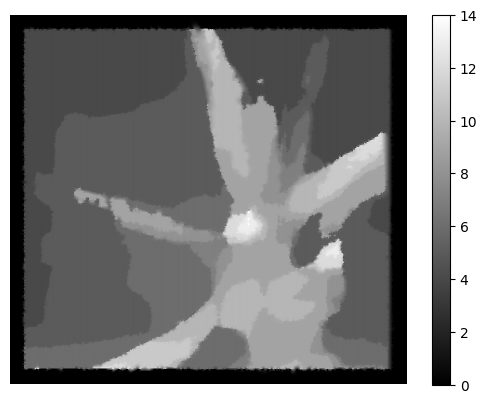

In [55]:
plt.imshow(depthMap, cmap='gray', aspect='auto')  # Equivalent to imagesc
plt.colorbar()  # Add color scale
plt.axis('off')  # Hide axes if needed
plt.show()

In [63]:
ground_truth = cv2.imread('../../data/Aloe/disp1.png', cv2.IMREAD_GRAYSCALE).astype(np.float64)

In [10]:
def getSAD(gt, pred):
    return np.sum(np.abs(gt - pred))

def getSSD(gt, pred):
    return np.sum((gt - pred) ** 2)

def immse(gt, pred):
    return mean_squared_error(gt.flatten(), pred.flatten())

In [82]:
ground_truth_norm = ground_truth/max(ground_truth.flatten())
depthMap_norm = depthMap/max(depthMap.flatten())

In [ ]:
score = np.zeros(4)
score[3] = ssim(depthMap, ground_truth, data_range=1.0)
score[0] = getSAD(ground_truth_norm, depthMap_norm)
score[1] = getSSD(ground_truth_norm, depthMap_norm)
score[2] = immse(ground_truth_norm, depthMap_norm)
print("Sum of absolute distances = ", score[0])
print("Sum of squared distances = ", score[1])
print("Mean squared error = ", score[2])
print("ssim = ", score[3])

Sum of absolute distances =  23361.04617796431
Sum of squared distances =  6716.923684719452
Mean squared error =  0.04251486603404932
ssim =  0.015499353472122817


In [11]:
def Stereo_function(left_image_path, right_image_path, ground_truth_path, maxDisparity, maxOffset, minDisparity, minOffset, windowsize, windowRange):
  # Load and preprocess images
  left_image = cv2.imread(left_image_path, cv2.IMREAD_GRAYSCALE).astype(np.float64)
  right_image = cv2.imread(right_image_path, cv2.IMREAD_GRAYSCALE).astype(np.float64)

  # Define Canny edge detection parameters
  high_threshold = 0.01 * 255  # Scale the threshold to match OpenCV's range (0-255)
  low_threshold = 0.4 * high_threshold  # MATLAB's 'edge' function automatically adjusts the high threshold

  # Apply Canny edge detection
  edge_right = cv2.Canny(right_image.astype(np.uint8), low_threshold, high_threshold)
  edge_left = cv2.Canny(left_image.astype(np.uint8), low_threshold, high_threshold)

  # Display the edge images
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(edge_left, cmap='gray')
  plt.title('Edge Left')
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.imshow(edge_right, cmap='gray')
  plt.title('Edge Right')
  plt.axis('off')
  plt.show()

  height, width = right_image.shape
  disparityMap, dispnotoutofbounds = computeDisparityMap(left_image, right_image, edge_right, windowsize, windowRange, height, width, maxOffset)

  plt.imshow(disparityMap, cmap='gray', aspect='auto')  # Equivalent to imagesc
  plt.colorbar()  # Add color scale
  plt.axis('off')  # Hide axes if needed
  plt.show()

  depthMap = depthretrieval(disparityMap, 2000, edge_right, height, width)

  plt.imshow(depthMap, cmap='gray', aspect='auto')  # Equivalent to imagesc
  plt.colorbar()  # Add color scale
  plt.axis('off')  # Hide axes if needed
  plt.show()

  ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE).astype(np.float64)

  score = np.zeros(3)
  score[0] = getSAD(ground_truth, depthMap)
  score[1] = getSSD(ground_truth, depthMap)
  score[2] = immse(ground_truth, depthMap)
  print("Sum of absolute distances = ", score[0])
  print("Sum of squared distances = ", score[1])
  print("Mean squared error = ", score[2])

  return depthMap, score

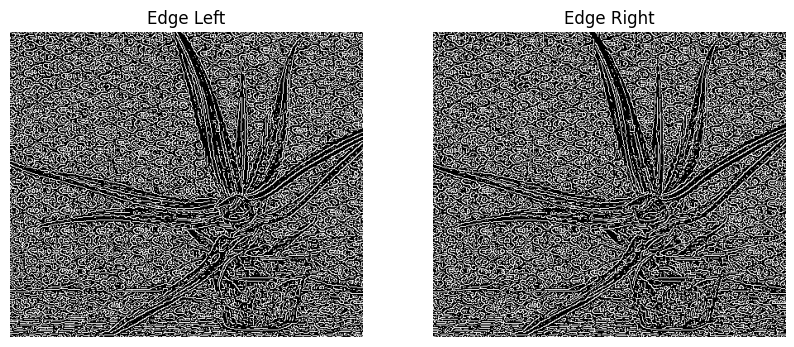

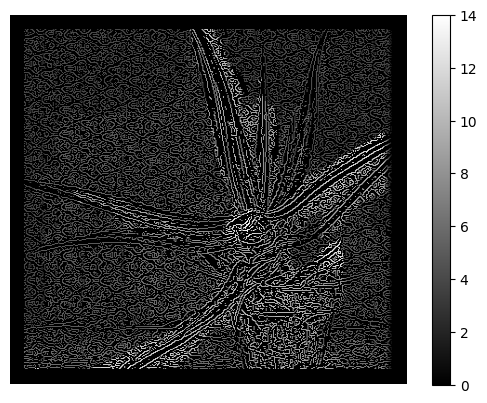

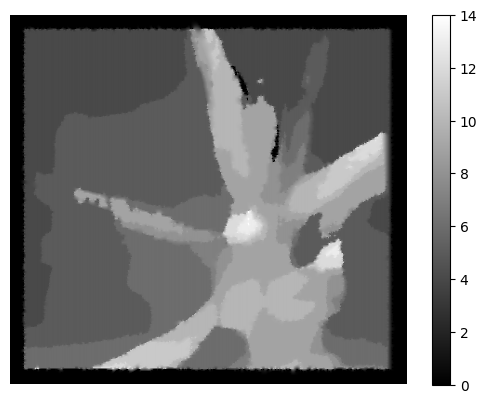

Sum of absolute distances =  10341485.146581449
Sum of squared distances =  801807123.8459029
Mean squared error =  5075.04983762202


In [76]:
[depthMap_aloe, score_aloe] = Stereo_function('../../data/Aloe/view0.png', '../../data/Aloe/view1.png', '../../data/Aloe/disp1.png', maxDisparity, maxOffset, minDisparity, minOffset, windowsize, windowRange)

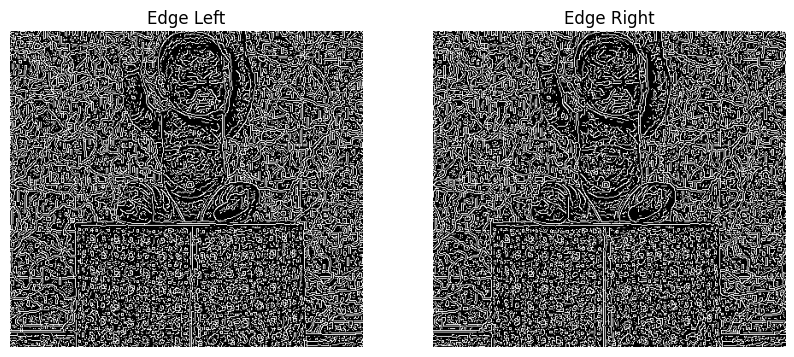

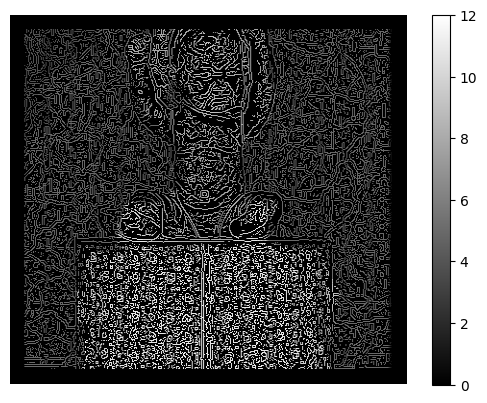

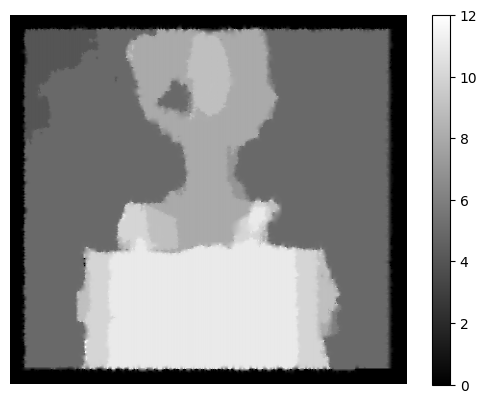

Sum of absolute distances =  11811748.262902036
Sum of squared distances =  1050121395.5675542
Mean squared error =  6872.07247933744


In [77]:
[depthMap_baby1, score_baby1] = Stereo_function('../../data/Baby1/view0.png', '../../data/Baby1/view1.png', '../../data/Baby1/disp1.png', maxDisparity, maxOffset, minDisparity, minOffset, windowsize, windowRange)